In [6]:
import math
import os
import time

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from model import aagcn, loss, SAM
from utils import adj_mat, training_supervision
from data.handpose_dataset import HandPoseDatasetNumpy, df_to_numpy
from data.get_data_from_csv import get_train_data, get_val_data
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import sklearn
from config_fine_tuning_occluded_hand_detection import CFG

Import model

In [7]:
model_path = 'trained_models/7_AAGCN_Focal_seqlen32_release_SAM_joints1_joints2_oridist/f10.8142688679245284_valloss310.2437744140625_epoch13.pth'

graph = aagcn.Graph(adj_mat.num_node, adj_mat.self_link, adj_mat.inward, adj_mat.outward, adj_mat.neighbor)

model = aagcn.Model(num_class=CFG.num_classes, num_point=21, num_person=1, graph=graph, drop_out=0.5,
                    in_channels=CFG.num_feats)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


Model(
  (data_bn): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): TCN_GCN_unit(
    (gcn1): unit_gcn(
      (conv_d): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_a): ModuleList(
        (0-2): 3 x Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_b): ModuleList(
        (0-2): 3 x Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_ta): Conv1d(64, 1, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv_sa): Conv1d(64, 1, kernel_size=(21,), stride=(1,), padding=(10,))
      (fc1c): Linear(in_features=64, out_features=32, bias=True)
      (fc2c): Linear(in_features=32, out_features=64, bias=True)
      (down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Modify model -> 3 classes

In [3]:
#num_classes_fine_tuning = len(CFG.classes_fine_tuning)

# change last layer
#model.fc = nn.Linear(128, num_classes_fine_tuning).to(device)

# init the new layer
#nn.init.normal_(model.fc.weight, 0, math.sqrt(2. / num_classes_fine_tuning))

Parameter containing:
tensor([[ 7.0185e-02,  2.4771e-01,  3.9396e-01, -8.9168e-01, -3.9525e-01,
         -2.9742e-01,  9.7565e-01, -7.8637e-01,  2.3552e-01, -1.1848e-02,
         -1.7289e-01, -4.1561e-01,  1.3128e+00, -1.3293e-01, -7.3596e-01,
          6.0861e-01, -3.7974e-01, -3.4785e-01,  1.5284e-01,  1.9753e+00,
         -9.3133e-02, -1.1806e+00, -1.0907e+00, -6.5592e-01,  5.7587e-01,
          7.9708e-01, -1.7051e+00,  9.7193e-01, -1.1896e+00,  9.7583e-01,
         -1.7357e-01,  3.0579e-02,  6.1332e-01,  2.7959e-01,  3.5409e-01,
          4.4103e-01,  3.3847e-02,  8.6670e-01, -1.2781e-01, -8.7633e-02,
         -7.7093e-01,  7.0282e-01,  7.6958e-01,  5.4175e-03,  3.7363e-01,
          6.8676e-01,  3.3440e-01,  8.1575e-02,  4.9630e-01,  8.7347e-01,
          2.6750e-01,  4.1464e-01, -7.0487e-01, -4.8187e-01, -9.1393e-02,
         -1.4350e+00,  5.2016e-01, -3.4967e-01,  1.1869e+00,  5.2113e-01,
         -6.7805e-01, -2.2267e-01, -5.8908e-01, -4.9559e-01, -1.5941e-02,
          2.2645

Get data

In [12]:
df_custom_data = pd.read_csv("data/graphdata/custom_data/test_big.csv")
df_custom_data = df_custom_data.drop("Unnamed: 0", axis=1)
print("[INFO] ALL CUSTOM DATA DISTRIBUTION")
print(df_custom_data["LABEL"].value_counts())

[INFO] ALL CUSTOM DATA DISTRIBUTION
LABEL
Move        1088
Grasp       1024
Reach        640
Position     576
Release      544
Negative     288
Name: count, dtype: int64


In [14]:
df_train = df_custom_data
#df_train = df_train.replace("Postion", "Position")
df_val = pd.read_csv("data/graphdata/custom_data/test_all_gestures.csv")
df_val = df_val.drop("Unnamed: 0", axis=1)

print("[INFO] VAL DATA DISTRIBUTION")
print(df_val["LABEL"].value_counts())

[INFO] VAL DATA DISTRIBUTION
LABEL
Grasp       32
Move        32
Negative    32
Position    32
Reach       32
Release     32
Name: count, dtype: int64


Finetuning first try: remove all other classes except our 3 from the data

In [5]:
#df_train = df_train[df_train["LABEL"].isin(CFG.classes_fine_tuning)]
#df_val = df_val[df_val["LABEL"].isin(CFG.classes_fine_tuning)]
#df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27184 entries, 0 to 2021
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   WRIST              27184 non-null  object
 1   THUMB_CMC          27184 non-null  object
 2   THUMB_MCP          27184 non-null  object
 3   THUMB_IP           27184 non-null  object
 4   THUMB_TIP          27184 non-null  object
 5   INDEX_FINGER_MCP   27184 non-null  object
 6   INDEX_FINGER_PIP   27184 non-null  object
 7   INDEX_FINGER_DIP   27184 non-null  object
 8   INDEX_FINGER_TIP   27184 non-null  object
 9   MIDDLE_FINGER_MCP  27184 non-null  object
 10  MIDDLE_FINGER_PIP  27184 non-null  object
 11  MIDDLE_FINGER_DIP  27184 non-null  object
 12  MIDDLE_FINGER_TIP  27184 non-null  object
 13  RING_FINGER_MCP    27184 non-null  object
 14  RING_FINGER_PIP    27184 non-null  object
 15  RING_FINGER_DIP    27184 non-null  object
 16  RING_FINGER_TIP    27184 non-null  object
 17 

Prepare train and validation data

In [15]:
print("[INFO] TRAIN DATA DISTRIBUTION")
print(df_train["LABEL"].value_counts())
print("[INFO] VALIDATION DATA DISTRIBUTION")
print(df_val["LABEL"].value_counts())

train_numpy = df_to_numpy(df_train)
val_numpy = df_to_numpy(df_val)

train_set = HandPoseDatasetNumpy(train_numpy)
val_set = HandPoseDatasetNumpy(val_numpy)

train_loader = DataLoader(train_set, batch_size=CFG.batch_size, drop_last=True, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=CFG.batch_size, drop_last=True, pin_memory=True)

print(f"[INFO] TRAINING ON {len(train_set)} DATAPOINTS")
print(f"[INFO] VALIDATION ON {len(val_set)} DATAPOINTS")

[INFO] TRAIN DATA DISTRIBUTION
LABEL
Move        1088
Grasp       1024
Reach        640
Position     576
Release      544
Negative     288
Name: count, dtype: int64
[INFO] VALIDATION DATA DISTRIBUTION
LABEL
Grasp       32
Move        32
Negative    32
Position    32
Reach       32
Release     32
Name: count, dtype: int64
[INFO] TRAINING ON 4160 DATAPOINTS
[INFO] VALIDATION ON 192 DATAPOINTS


Fine tuning config and preparation

In [16]:
optimizer_base = torch.optim.Adam
optimizer = SAM.SAM(model.parameters(), optimizer_base, lr=CFG.lr, rho=0.5, adaptive=True)
criterion = loss.FocalLoss()

writer = SummaryWriter(f'fine_tuned_models_occluded_hand_detection/runs/{CFG.experiment_name}')

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=CFG.min_lr)

In [17]:
def train_func(model, data_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    iters = len(data_loader)
    global_step = epoch * len(data_loader)
    preds = []
    groundtruth = []
    t0 = time.time()
    loss_total = 0
    for i, (inputs, labels) in enumerate(data_loader):
        labels = labels.cuda().long()
        inputs = inputs.cuda().float()

        last_label = labels[:, -1, :]
        last_label = torch.argmax(last_label, 1)

        model.zero_grad()
        last_out = model(inputs)

        # first forward-backward pass
        loss = criterion(last_out, last_label)
        loss.backward()

        if CFG.sam:
            optimizer.first_step(zero_grad=True)  #

            # second forward-backward pass
            criterion(model(inputs), last_label).backward()  #
            optimizer.second_step(zero_grad=True)  #
        else:
            optimizer.step()

        current_lr = optimizer.param_groups[0]['lr']

        preds.append(last_out.cpu().detach().numpy())
        groundtruth.append(last_label.cpu().detach().numpy())

        loss_total += loss
        global_step += 1
        writer.add_scalar('Loss/Train', loss, global_step)
        writer.add_scalar('LR', current_lr, global_step)

        if i % CFG.print_freq == 1 or i == iters - 1:
            t1 = time.time()
            print(
                f"[TRAIN] Epoch: {epoch}/{CFG.epochs} | Iteration: {i}/{iters} | Loss: {loss_total / i} | LR: {current_lr} | ETA: {((t1 - t0) / i * iters) - (t1 - t0)}s")

    return loss_total, np.argmax(preds, axis=2).flatten(), np.array(groundtruth).flatten()


def eval_func(model, criterion, data_loader, epoch):
    model.eval()
    preds = []
    groundtruth = []
    t0 = time.time()
    loss_total = 0
    global_step = len(train_loader) * epoch
    iters = len(data_loader)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            labels = labels.cuda().long()
            inputs = inputs.cuda().float()

            last_label = labels[:, -1, :]
            last_label = torch.argmax(last_label, 1)

            last_out = model(inputs)
            loss = criterion(last_out, last_label)

            preds.append(last_out.cpu().detach().numpy())
            groundtruth.append(last_label.cpu().detach().numpy())
            loss_total += loss

            if i % CFG.print_freq == 1 or i == iters - 1:
                t1 = time.time()
                print(
                    f"[EVAL] Epoch: {epoch}/{CFG.epochs} | Iteration: {i}/{iters} | Val-Loss: {loss_total / i} | ETA: {((t1 - t0) / i * iters) - (t1 - t0)}s")

    writer.add_scalar('Loss/Validation', loss_total / i, global_step)
    return loss_total, np.argmax(preds, axis=2).flatten(), np.array(groundtruth).flatten()

Early stopping to stop training automatically when model doesn't improve anymore

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


early_stopping = EarlyStopping(patience=10, delta=0.001)

Start Fine tuning

[TRAIN] Epoch: 0/500 | Iteration: 1/260 | Loss: 0.27376827597618103 | LR: 0.0001 | ETA: 197.21235251426697s
[TRAIN] Epoch: 0/500 | Iteration: 101/260 | Loss: 0.04461438208818436 | LR: 0.0001 | ETA: 35.9036138152132s
[TRAIN] Epoch: 0/500 | Iteration: 201/260 | Loss: 0.04155543074011803 | LR: 0.0001 | ETA: 13.15433788180944s
[TRAIN] Epoch: 0/500 | Iteration: 259/260 | Loss: 0.038388464599847794 | LR: 0.0001 | ETA: 0.22232238758484613s
[TRAIN] Training F1-Score 0.9673076923076923


C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[EVAL] Epoch: 0/500 | Iteration: 1/12 | Val-Loss: 3.1926534175872803 | ETA: 0.6767420768737793s
[EVAL] Epoch: 0/500 | Iteration: 11/12 | Val-Loss: 2.3044559955596924 | ETA: 0.03364721211520105s
[EVAL] Validation F1-Score Micro 0.3020833333333333
[EVAL] Validation F1-Score Macro 0.2172474209407168
[EVAL] Classification Report
              precision    recall  f1-score   support

       Grasp      0.026     1.000     0.051         1
        Move      0.129     0.250     0.170        32
    Negative      0.000     0.000     0.000        32
    Position      0.391     0.281     0.327        32
       Reach      0.000     0.000     0.000        32
     Release      0.930     0.635     0.755        63

    accuracy                          0.302       192
   macro avg      0.246     0.361     0.217       192
weighted avg      0.392     0.302     0.331       192

[INFO] MODEL SAVED
[TRAIN] Epoch: 1/500 | Iteration: 1/260 | Loss: 0.017396291717886925 | LR: 0.0001 | ETA: 115.28987169265747s
[T

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[EVAL] Epoch: 1/500 | Iteration: 1/12 | Val-Loss: 2.7926063537597656 | ETA: 0.6821446418762207s
[EVAL] Epoch: 1/500 | Iteration: 11/12 | Val-Loss: 2.274810791015625 | ETA: 0.03423909707502887s
[EVAL] Validation F1-Score Micro 0.3125
[EVAL] Validation F1-Score Macro 0.2278549418559638
[EVAL] Classification Report
              precision    recall  f1-score   support

       Grasp      0.027     1.000     0.053         1
        Move      0.159     0.312     0.211        32
    Negative      0.000     0.000     0.000        32
    Position      0.391     0.281     0.327        32
       Reach      0.000     0.000     0.000        32
     Release      1.000     0.635     0.777        63

    accuracy                          0.312       192
   macro avg      0.263     0.371     0.228       192
weighted avg      0.420     0.312     0.345       192

[INFO] MODEL SAVED
[TRAIN] Epoch: 2/500 | Iteration: 1/260 | Loss: 0.05735614895820618 | LR: 0.0001 | ETA: 117.23636817932129s
[TRAIN] Epoch: 2

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[EVAL] Epoch: 2/500 | Iteration: 1/12 | Val-Loss: 2.0325443744659424 | ETA: 0.7097764015197754s
[EVAL] Epoch: 2/500 | Iteration: 11/12 | Val-Loss: 2.5276851654052734 | ETA: 0.03392041813243518s
[EVAL] Validation F1-Score Micro 0.3802083333333333
[EVAL] Validation F1-Score Macro 0.28219960676101025
[EVAL] Classification Report
              precision    recall  f1-score   support

       Grasp      0.024     1.000     0.048         1
        Move      0.179     0.375     0.242        32
    Negative      0.000     0.000     0.000        32
    Position      0.640     0.500     0.561        32
       Reach      0.083     0.031     0.045        32
     Release      0.956     0.683     0.796        63

    accuracy                          0.380       192
   macro avg      0.314     0.431     0.282       192
weighted avg      0.464     0.380     0.403       192

[INFO] MODEL SAVED
[TRAIN] Epoch: 3/500 | Iteration: 1/260 | Loss: 0.09926934540271759 | LR: 0.0001 | ETA: 117.2626121044159s
[TR

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[EVAL] Epoch: 3/500 | Iteration: 1/12 | Val-Loss: 2.2800564765930176 | ETA: 0.6877543926239014s
[EVAL] Epoch: 3/500 | Iteration: 11/12 | Val-Loss: 2.6655209064483643 | ETA: 0.03343558311462402s
[EVAL] Validation F1-Score Micro 0.3802083333333333
[EVAL] Validation F1-Score Macro 0.2848988507485745
[EVAL] Classification Report
              precision    recall  f1-score   support

       Grasp      0.040     1.000     0.077         1
        Move      0.216     0.500     0.302        32
    Negative      0.000     0.000     0.000        32
    Position      0.517     0.469     0.492        32
       Reach      0.091     0.062     0.074        32
     Release      1.000     0.619     0.765        63

    accuracy                          0.380       192
   macro avg      0.311     0.442     0.285       192
weighted avg      0.466     0.380     0.396       192

[INFO] MODEL SAVED
[TRAIN] Epoch: 4/500 | Iteration: 1/260 | Loss: 0.004495765548199415 | LR: 0.0001 | ETA: 115.03237247467041s


KeyboardInterrupt: 

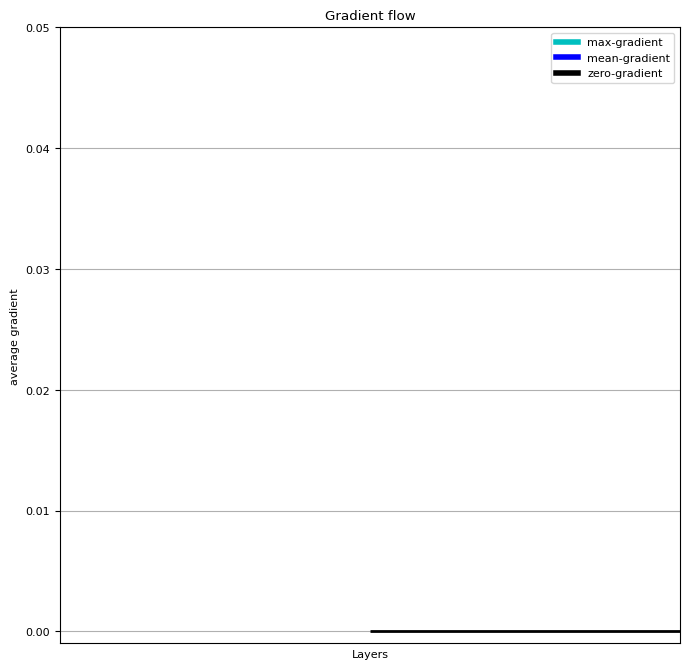

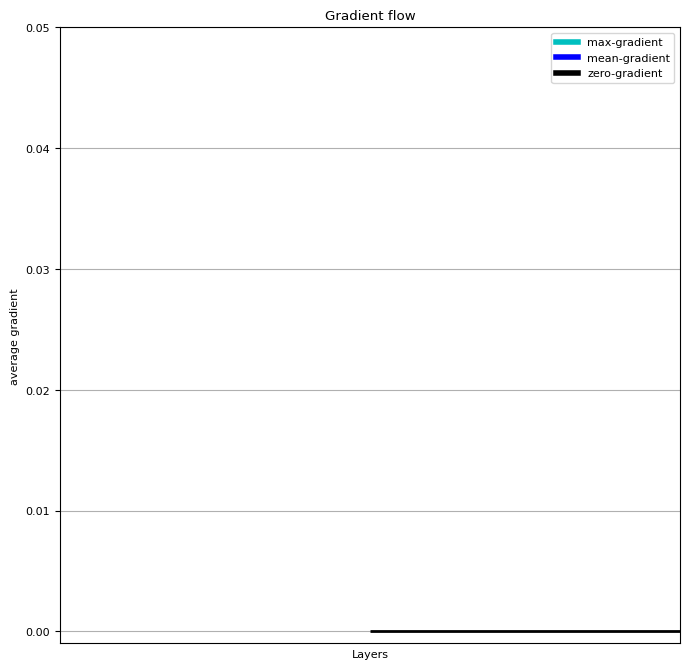

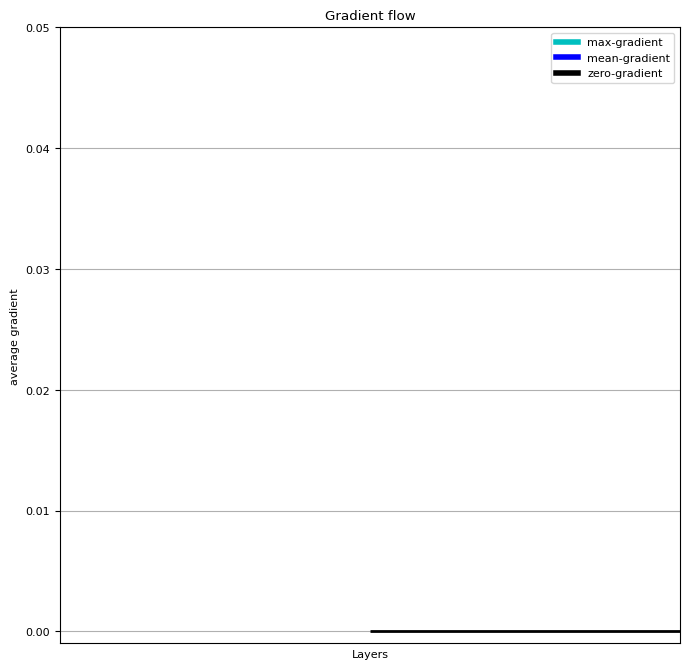

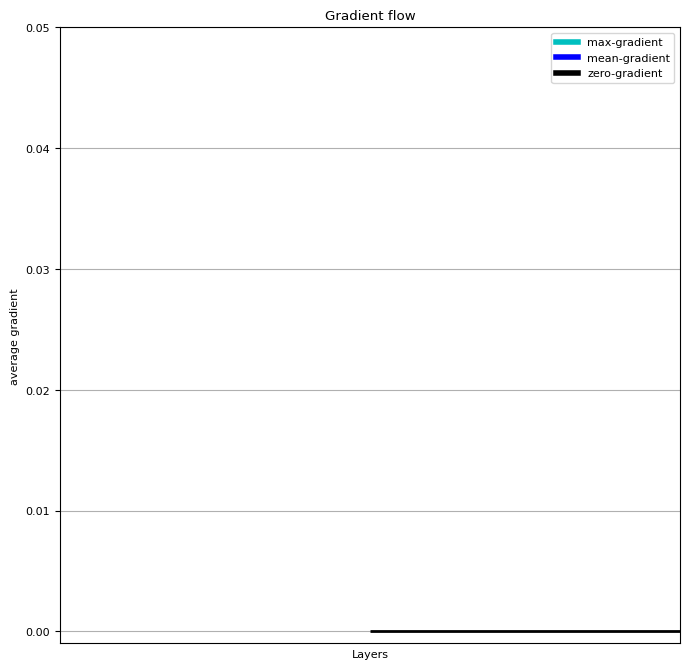

In [21]:
start_epoch = 0

for epoch in range(start_epoch, CFG.epochs + start_epoch):
    global_step = len(train_loader) * epoch

    #TRAIN
    train_loss, preds_train, gt_train = train_func(model, train_loader, criterion, optimizer, scheduler, epoch)
    train_grad_flow_plot = training_supervision.get_plot_grad_flow(model)

    f1_train = f1_score(gt_train, preds_train, average="micro")
    writer.add_scalar('Accuracy/Train', f1_train, global_step)
    print(f"[TRAIN] Training F1-Score {f1_train}")

    #Model Gradients
    names, gradmean = training_supervision.get_model_grads(model)
    _limits = np.array([float(i) for i in range(len(gradmean))])
    _num = len(gradmean)
    writer.add_histogram_raw(tag="ModelGrads/MeanGradientFlow", min=0.0, max=0.5, num=_num,
                             sum=gradmean.sum(), sum_squares=np.power(gradmean, 2).sum(), bucket_limits=_limits,
                             bucket_counts=gradmean, global_step=global_step)

    #VAL
    val_loss, preds_val, gt_val = eval_func(model, criterion, val_loader, epoch)

    f1_val_micro = f1_score(gt_val, preds_val, average="micro")
    f1_val_macro = f1_score(gt_val, preds_val, average="macro")
    writer.add_scalar('Accuracy/Validation/F1-Micro', f1_val_micro, global_step)
    writer.add_scalar('Accuracy/Validation/F1-Macro', f1_val_macro, global_step)
    print(f"[EVAL] Validation F1-Score Micro {f1_val_micro}")
    print(f"[EVAL] Validation F1-Score Macro {f1_val_macro}")

    #Conf Mat
    cm = sklearn.metrics.confusion_matrix(gt_val, preds_val)
    cm_plot = training_supervision.plot_confusion_matrix(cm, CFG.classes)
    writer.add_figure("Confusion Matrix/Validation", cm_plot, global_step)

    #Model Weights
    names, params = training_supervision.get_model_weights(model)
    for n, p in zip(names, params):
        writer.add_histogram(f"ModelWeights/{n}", p, global_step)

    print("[EVAL] Classification Report")
    print(classification_report(gt_val, preds_val, target_names=CFG.classes, digits=3))

    scheduler.step(val_loss)  #for reduce lr on plateau

    import os
    os.makedirs(f"fine_tuned_models_occluded_hand_detection/{CFG.experiment_name}", exist_ok=True)
    PATH = f"fine_tuned_models_occluded_hand_detection/{CFG.experiment_name}/f1{f1_val_micro}_valloss{val_loss}_epoch{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'f1_micro_val-score': f1_val_micro,
    }, PATH)
    print("[INFO] MODEL SAVED")
    
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break